In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
current_path = os.getcwd()
previous_path = os.chdir("..")
sys.path.append(current_path)
sys.path.append(previous_path)

In [2]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from data_fitting.module_fitzcu import *
from expt_cfg import tof_config, config

from qick import *
# for now, all the tProc v2 classes need to be individually imported (can't use qick.*)
# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSpan, QickSweep1D

import json
import datetime
import pprint as pp

ModuleNotFoundError: No module named 'data_fitting'

In [5]:
import Pyro4
from qick import QickConfig
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

ns_host = "192.168.10.97"
ns_port = 8888
proxy_name = "myqick"

ns = Pyro4.locateNS(host=ns_host, port=ns_port)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
print(soccfg)

QICK running on ZCU216, software version 0.2.302

Firmware configuration (built Tue Sep 10 16:13:40 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	16 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 16384 samples (1.709 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 4096 samples (0.427 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 8192 samples (0.855 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 4096 samples (0.427 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_sg_int4_v2 - envelope memory 16384 samples (38.095 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 3

In [7]:
class SingleShotProgram_g(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        res_ch = cfg['res_ch']
        qubit_ch = cfg['qubit_ch']
        
        self.declare_gen(ch=res_ch, nqz=cfg['nqz_res'])
        self.declare_gen(ch=qubit_ch, nqz=cfg['nqz_qubit'])

        # pynq configured
        # self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['f_res'], gen_ch=res_ch)
        
        # tproc configured
        self.declare_readout(ch=ro_ch, length=cfg['ro_length'])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['res_freq_ge'], gen_ch=res_ch)

        self.add_loop("shotloop", cfg["steps"]) # number of total shots

        self.add_pulse(ch=res_ch, name="res_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['res_length'], 
                       freq=cfg['res_freq_ge'], 
                       phase=cfg['res_phase'],
                       gain=cfg['res_gain_ge'],
                      )

    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        # no qubit pulse
        self.delay_auto(0.01, tag='wait')
        self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0) # play probe pulse
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

class SingleShotProgram_e(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        res_ch = cfg['res_ch']
        qubit_ch = cfg['qubit_ch']
        
        self.declare_gen(ch=res_ch, nqz=cfg['nqz_res'])
        self.declare_gen(ch=qubit_ch, nqz=cfg['nqz_qubit'])

        # pynq configured
        # self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['f_res'], gen_ch=res_ch)
        
        # tproc configured
        self.declare_readout(ch=ro_ch, length=cfg['ro_length'])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['res_freq_ge'], gen_ch=res_ch)

        self.add_loop("shotloop", cfg["steps"]) # number of total shots

        self.add_pulse(ch=res_ch, name="res_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['res_length'], 
                       freq=cfg['res_freq_ge'], 
                       phase=cfg['res_phase'],
                       gain=cfg['res_gain_ge'],
                      )
        
        self.add_gauss(ch=qubit_ch, name="ramp", sigma=cfg['sigma'], length=cfg['sigma']*5, even_length=True)
        self.add_pulse(ch=qubit_ch, name="qubit_pulse", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['qubit_freq_ge'], 
                       phase=cfg['qubit_phase'],
                       gain= cfg['qubit_gain_ge'], 
                      )

    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_pulse", t=0)  #play pulse
        self.delay_auto(0.01, tag='wait')
        self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0) # play probe pulse
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

class SingleShotProgram_f(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        res_ch = cfg['res_ch']
        qubit_ch = cfg['qubit_ch']
        
        self.declare_gen(ch=res_ch, nqz=cfg['nqz_res'])
        self.declare_gen(ch=qubit_ch, nqz=cfg['nqz_qubit'])

        # pynq configured
        # self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['f_res'], gen_ch=res_ch)
        
        # tproc configured
        self.declare_readout(ch=ro_ch, length=cfg['ro_length'])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['res_freq_ge'], gen_ch=res_ch)

        self.add_loop("shotloop", cfg["steps"]) # number of total shots

        self.add_pulse(ch=res_ch, name="res_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['res_length'], 
                       freq=cfg['res_freq_ge'], 
                       phase=cfg['res_phase'],
                       gain=cfg['res_gain_ge'],
                      )
        
        self.add_gauss(ch=qubit_ch, name="ramp_ge", sigma=cfg['sigma'], length=cfg['sigma']*5, even_length=True)
        self.add_pulse(ch=qubit_ch, name="qubit_ge_pulse", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp_ge", 
                       freq=cfg['qubit_freq_ge'], 
                       phase=cfg['qubit_phase'],
                       gain= cfg['qubit_gain_ge'], 
                      )
        
        self.add_gauss(ch=qubit_ch, name="ramp_ef", sigma=cfg['sigma'], length=cfg['sigma']*5, even_length=True)
        self.add_pulse(ch=qubit_ch, name="qubit_ef_pulse", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp_ef", 
                       freq=cfg['qubit_freq_ef'], 
                       phase=cfg['qubit_phase'],
                       gain= cfg['qubit_gain_ef'], 
                      )
        
    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_ge_pulse", t=0)  #play pulse
        self.delay_auto(0.01, tag='wait1')
        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_ef_pulse", t=0)  #play pulse
        self.delay_auto(0.01)
        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_ge_pulse", t=0)  #play pulse
        self.delay_auto(0.01)
        self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0) # play probe pulse
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])


In [18]:
STEP = 1000
config = {
    'steps': STEP,
    ## Channel Params. ##
    'res_ch': 0,
    'ro_ch': 0,
    'qubit_ch': 1,

    ## Resonator Pulse Params. ##
    'res_freq_ge': 5000,  # [MHz]
    'nqz_res':2,
    'res_length': 6.0,  # [us]
    'res_phase': 0,  # [deg]
    'res_gain_ge': 0.1,  # [DAC units]

    ## Readout Params. ##
    'trig_time': 0.65,  # [us]
    'ro_length': 8.0,  # [us]
    'relax_delay': 10,  # [us]

    ## Qubit Params. ##
    'nqz_qubit':2,
    'qubit_freq_ge': 4000,  # [MHz]
    'qubit_gain_ge': 0.1,

    'qubit_freq_ef':0.1,
    'qubit_gain_ef':0.1,
    
    'qubit_phase': 0,
    'probe_len': 5,
    'sigma': 0.01,
    'ramsey_freq': 5,  # [MHz]
}


In [19]:
ssp_g = SingleShotProgram_g(soccfg, reps=1, final_delay=config['relax_delay'], cfg=config)
iq_list_g = ssp_g.acquire(soc, soft_avgs=1, progress=True)

ssp_e = SingleShotProgram_e(soccfg, reps=1, final_delay=config['relax_delay'], cfg=config)
iq_list_e = ssp_e.acquire(soc, soft_avgs=1, progress=True)

ssp_f = SingleShotProgram_f(soccfg, reps=1, final_delay=config['relax_delay'], cfg=config)
iq_list_f = ssp_f.acquire(soc, soft_avgs=1, progress=True)

I_g = iq_list_g[0][0].T[0]
Q_g = iq_list_g[0][0].T[1]
I_e = iq_list_e[0][0].T[0]
Q_e = iq_list_e[0][0].T[1]
I_f = iq_list_f[0][0].T[0]
Q_f = iq_list_f[0][0].T[1]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

g unrotated averages:
I -10.757505288852725 +/- 0.0310022159260349 	 Q -1.8570504475183076 +/- 0.03519659510986059 	 Amp 10.91667449264248 +/- 0.03121479955069535
Rotated (theta=1.4976365026323362):
I 1.0657675459763547 +/- 0.03514327058880118 	 Q -10.864469427554475 +/- 0.031062650111898904 	 Amp 10.916618359378619 +/- 0.03121479955069535
e unrotated averages:
I -10.759223759153786 +/- 0.03243633214540903 	 Q -1.8555813669650125 +/- 0.03387895268847965 	 Amp 10.918114520291095 +/- 0.03245504358511695
Rotated (theta=1.4976365026323362):
I 1.0641767843310745 +/- 0.03388097916820505 	 Q -10.866075919146606 +/- 0.032434215404711024 	 Amp 10.918062012507852 +/- 0.03245504358511695
f unrotated averages:
I -10.757104963384867 +/- 0.03298927418643133 	 Q -1.862512611879577 +/- 0.033969019276594986 	 Amp 10.917207690896987 +/- 0.032845745409054584
Rotated (theta=1.4976365026323362):
I 1.0712443607431454 +/- 0.03403624024571738 	 Q -10.864469427554472 +/- 0.032919915429676164 	 Amp 10.917154410

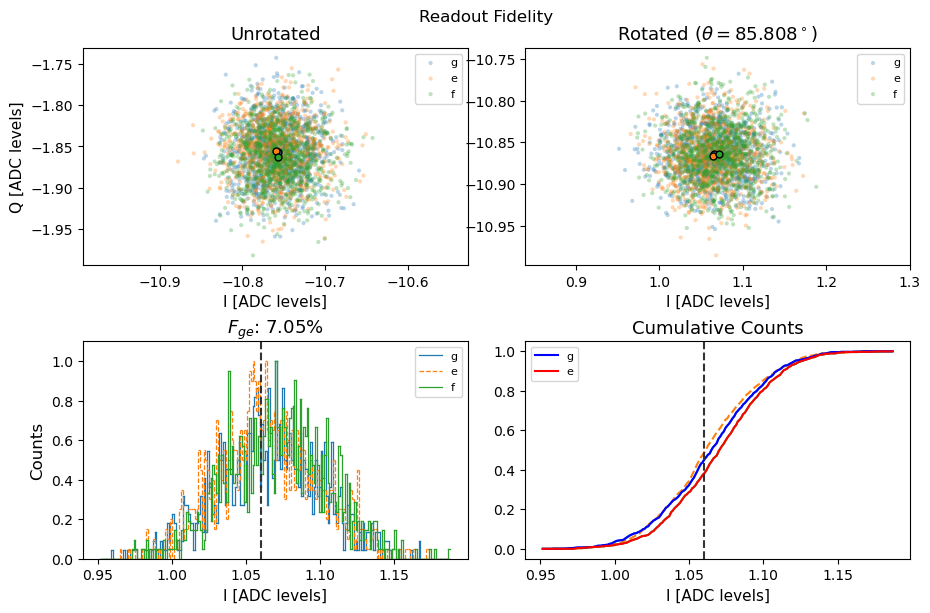

[[0.07045345345345316], [1.0603982133672245], 85.80825084556608]

In [20]:
from singleshotplot import *

data = {
    'Ig':I_g,
    'Qg':Q_g,
    'Ie':I_e,
    'Qe':Q_e,
    'If':I_f,
    'Qf':Q_f,
}

hist(
    data,
    amplitude_mode=False,
    ps_threshold=None,
    theta=None,
    plot=True,
    verbose=True,
    fid_avg=False,
    fit=False,
    fitparams=None,
    normalize=True,
    title=None,
    export=False,
)